In [490]:
import networkx as nx
import cirq
import numpy as np
from matplotlib import pyplot as plt

In [491]:
class Gate:
    def __init__(self, gname, *args):
        self.name = gname
        self.qs = []
        for i in args:
            self.qs.append(i)
    
    def apply(self, *qubits):
        return getattr(cirq, self.name)(qubits)

### Generate Gate Sequence

In [521]:
num_q = 5
depth = 3
oneq_gates = ["T", "rx", "ry"]
inv_prob = [len(oneq_gates) for i in range(len(oneq_gates))]
gates = []

nodes = []

for i in range(num_q):
    gates.append(Gate("H", i))
    nodes.append((i, {"subset" : 0}))

cnt = num_q
for i in range(depth):
    lst = [i for i in range(num_q - 1)]
    lst_fin = []
    while len(lst) > 0:
        v = np.random.choice(lst)
        if np.random.random() > 0.1:
            lst_fin.append(v)
        lst.remove(v)
        if (v + 1) in lst:
            lst.remove(v + 1)
        if (v - 1) in lst:
            lst.remove(v - 1)
    lst_fin = np.sort(lst_fin)
    for v in range(num_q):
        if v in lst_fin:
            gates.append(Gate("CZ", v, v + 1))
            nodes.append((cnt, {"subset" : 2 * i + 1}))
            cnt += 1
        elif v not in lst_fin and v not in lst_fin + 1:
            gates.append(Gate(""))
            nodes.append((cnt, {"subset" : 2 * i + 1}))
            cnt += 1

    gate = np.random.choice(oneq_gates, p = np.array([1. / i for i in inv_prob]) / sum([1. / i for i in inv_prob]))
    inv_prob[oneq_gates.index(gate)] += len(oneq_gates)
    for j in range(num_q):
        gates.append(Gate(gate, j))
        nodes.append((cnt, {"subset" : 2 * i + 2}))
        cnt += 1

In [522]:
for g in gates:
    print(g.name, g.qs)

H [0]
H [1]
H [2]
H [3]
H [4]
 []
CZ [1, 2]
CZ [3, 4]
ry [0]
ry [1]
ry [2]
ry [3]
ry [4]
CZ [0, 1]
CZ [2, 3]
 []
T [0]
T [1]
T [2]
T [3]
T [4]
 []
 []
 []
CZ [3, 4]
rx [0]
rx [1]
rx [2]
rx [3]
rx [4]


### Create Graph

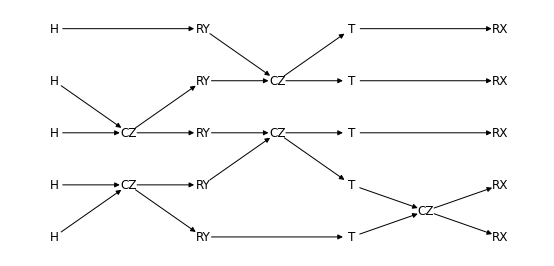

In [524]:
G = nx.DiGraph()
G.add_nodes_from(nodes)

cur_gate = np.array([i for i in range(num_q)])
cur = num_q
for gate in gates[num_q:]:
    for i in gate.qs:
        G.add_edge(cur_gate[i], cur)
        cur_gate[i] = cur
    cur += 1
    
pos = nx.multipartite_layout(G)
labeldict = {}
for i in range(len(gates)):
    labeldict[i] = gates[i].name.upper()
nx.draw(G, pos, labels = labeldict, with_labels = True, node_color = 'none')

### Simulate on LineQubit

In [525]:
q_line = cirq.LineQubit.range(num_q)
line_circuit = cirq.Circuit()

for gate in gates:        
    if len(gate.qs) == 1 and gate.name[0] != 'r':
        line_circuit.append(getattr(cirq, gate.name)(q_line[gate.qs[0]]))
    elif len(gate.qs) == 1:
        line_circuit.append(getattr(cirq, gate.name)(np.pi / 2)(q_line[gate.qs[0]]))
    elif len(gate.qs) == 2:
        line_circuit.append(getattr(cirq, gate.name)(q_line[gate.qs[0]], q_line[gate.qs[1]]))
print(line_circuit)
#barier

0: ───H───Ry(0.5π)──────────────@───T───Rx(0.5π)──────────────
                                │
1: ───H───@──────────Ry(0.5π)───@───T───Rx(0.5π)──────────────
          │
2: ───H───@──────────Ry(0.5π)───@───T───Rx(0.5π)──────────────
                                │
3: ───H───@──────────Ry(0.5π)───@───T───@──────────Rx(0.5π)───
          │                             │
4: ───H───@──────────Ry(0.5π)───T───────@──────────Rx(0.5π)───


In [526]:
sim = cirq.Simulator()
results = sim.simulate(line_circuit)
print(results)

measurements: (no measurements)
output vector: [-0.02588833+0.02588833j  0.06249999-0.06249996j -0.06249998-0.11427664j
  0.15088828+0.27588823j  0.06249997-0.06249999j -0.15088828+0.15088828j
 -0.0991116 +0.02588833j  0.23927659-0.06249997j  0.11427664+0.06249998j
 -0.27588823-0.15088828j  0.02588833-0.02588833j -0.06249996+0.06249999j
 -0.02588833+0.0991116j   0.06249997-0.23927659j -0.06249999+0.06249997j
  0.15088828-0.15088828j -0.02588833-0.02588833j  0.06249996+0.06249999j
  0.11427664-0.06249998j -0.27588823+0.15088828j  0.06249999+0.06249997j
 -0.15088828-0.15088828j -0.02588833-0.0991116j   0.06249997+0.23927659j
 -0.06249998+0.11427664j  0.15088828-0.27588823j  0.02588833+0.02588833j
 -0.06249999-0.06249996j -0.0991116 -0.02588833j  0.23927659+0.06249997j
 -0.06249997-0.06249999j  0.15088828+0.15088828j]


### Simulate with Swaps

In [517]:
# q_grid = np.empty((3, 3), dtype = cq.devices.grid_qubit.GridQubit)
# for i in range(2):
#     for j in range(3):
#         q_grid[i][j] = cirq.GridQubit(i, j)

In [518]:
q_cross = []
q_cross.append(cirq.GridQubit(0, 1))
q_cross.append(cirq.GridQubit(1, 0))
q_cross.append(cirq.GridQubit(1, 1))
q_cross.append(cirq.GridQubit(1, 2))
q_cross.append(cirq.GridQubit(2, 1))

In [520]:
q_cross

[cirq.GridQubit(0, 1),
 cirq.GridQubit(1, 0),
 cirq.GridQubit(1, 1),
 cirq.GridQubit(1, 2),
 cirq.GridQubit(2, 1)]

In [488]:
grid_circuit = cirq.Circuit()

In [489]:
grid_circuit

### Results